# TestingEvaluateClass

# Libraries

In [1]:
# directory set up 
import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir) 

# data attainment
import pandas as pd

# mathematical
import tensorflow as tf
import numpy as np

# preprocessing
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from Extra_Work.PythonFiles.preprocessing import scale_data

# modelling
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import LayerNormalization, BatchNormalization, Dense, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam
# evaluation
from Extra_Work.PythonFiles.modelling import evaluate_models
from Extra_Work.PythonFiles.modelling import FeedForward

# plotting
import matplotlib.pyplot as plt

# setting global seeds
#tf.random.set_seed(1)
#np.random.seed(1)

# Data

In [2]:
# load data

df = pd.read_csv('../Data/dataset2.csv')

X, scalers = scale_data(df[df.columns[:-1]], mode = 'minmax')
# for best model, put robust mode. Try with standard too
#X['Spring constant (N per m)'] = 0
#X['Ball radius (mm)'] = 0

y = df[df.columns[-1]]

y_binary = to_categorical(y)

data = train_test_split(
    X,y_binary, test_size = 0.2, random_state = 23
)
X.describe()

,Arm length (m),Ball weight (kg),Ball radius (mm),Air temperature (deg C),Spring constant (N per m),Device weight (kg)
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.398512,0.456403,0.158420,0.520185,0.191242,0.493725
std,0.156866,0.148990,0.111700,0.211920,0.128153,0.288167
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.292083,0.357587,0.085095,0.391304,0.101880,0.245800
50%,0.399114,0.456107,0.128587,0.521739,0.159880,0.493497
75%,0.500669,0.558048,0.201450,0.652174,0.243408,0.743594
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [3]:
X = np.asarray(X)

In [4]:
y_binary

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

# Data Exploration

# Model Cell

In [37]:
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras.activations import elu, relu 
from tensorflow.keras.layers import Activation
from tensorflow.keras.initializers import Constant

# add automation to this
def uncompiled_model():
    inputs = Input(shape=(6,), name='Data')
    x = Dense(16, activation = 'softmax', bias_initializer=Constant(0.5))(inputs) # had this before
    x = BatchNormalization()(x)
    x = Dense(8, activation='softmax', bias_initializer=Constant(0.5))(x)
    x = BatchNormalization()(x)
    x = Dense(16, activation='softmax')(x)
    x = BatchNormalization()(x)

    
    
    #x = Dropout(0.2)(x)

    # try adding weight constraints to model
    



    # meshi's
    #x = Dense(6, activation = 'tanh')(inputs)
    #x = Dense(6, activation = 'relu')(x)
    #x = Dense(4, activation = 'relu')(x)




    # and make sure that epochs = 250
    # update, best is 16,8,16 with batch = 50, epochs = 250
    # also 32,16,32
    
    #x = Dense(4, activation='sigmoid')(x)
    outputs = Dense(2, activation='softmax')(x)


# try maxout layers!!!!

    #outputs = Dense(2, activation='sigmoid', name='TargetHit')(x)
    # remember, you might have to make ur output a sigmoid!


    # chris model
    #x = Dense(3, activation='linear')(inputs)
    #outputs = Dense(2, activation = 'sigmoid')(x)
    
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

# will get penalised for model complexity, make sure you decrease this

def compile_model():
    model = uncompiled_model()
    model.compile(
        #optimizer="adam", # next step, add custom optimizers and modify learning 
        optimizer='RMSprop', # has potential for improvement but needs high epochs
        # rates. Adam yelds the best values
        loss="binary_crossentropy", # binary_crossentropy
        metrics=["accuracy",
                 "binary_accuracy",
                 "binary_crossentropy",
                 "categorical_accuracy"
                 ],
    )
    return model

def compiler(model):
    model.compile(
    optimizer=Adam(learning_rate=0.01), # was previously set to 0.1
    loss="mean_squared_error", # binary cross entropy
    metrics=["accuracy",
             "binary_accuracy",
             "binary_crossentropy",
             "categorical_accuracy"
             ],
    )
    return model
    

# Test Model

In [5]:
feedforward = FeedForward()


In [6]:
model = compile_model()
instance = evaluate_models(
    uncompiled_model(), compiler, *data
)

scores, histories = instance.cross_validate(epochs = 100, verbose = 0)


25/25 [==============================] - 0s 1ms/step - loss: 0.4103 - accuracy: 0.8325 - binary_accuracy: 0.8319 - binary_crossentropy: 0.4103 - categorical_accuracy: 0.8325
average loss:  0.44904146790504457
average accuracy:  0.8014999985694885


[0.74250001 0.80124998 0.80500001 0.82625002 0.83249998]


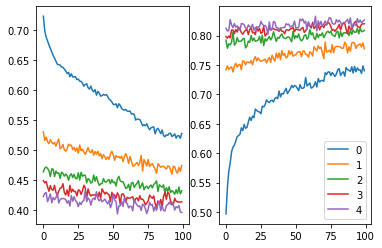

In [7]:
instance.plot_histories(histories)
print(np.asarray(scores)[:,1])

In [20]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(patience = 15)

from sklearn.model_selection import KFold
from time import time
def cross_validate(K = 5, **kwargs):
    scores = []
    histories = []
    X = np.concatenate((data[0], data[1]), axis = 0)
    y = np.concatenate((data[2], data[3]), axis = 0)
    for train, test in KFold(n_splits=K, shuffle=True).split(X,y):
        model = compile_model()
        start = time()
        histories.append(model.fit(X[train], y[train],
                                   validation_data = (X[test],y[test]),
                                   **kwargs).history)
        print(time() - start)
        scores.append(model.evaluate(X[test], y[test], verbose = 0))
    print("average loss: ", np.asarray(scores)[:,0].mean())
    print("average accuracy: ", np.asarray(scores)[:,1].mean()) # make sure that accuracy is the first metric in compile
    print(model.summary())
    #model = compile_model()
    #model.fit(data[0],data[2],**kwargs)
    #print(model.evaluate(data[1],data[3]))
    return scores, histories

def plot_histories(histories, metrics = ['loss', 'accuracy', 'val_accuracy','val_loss']):
    fig, axes = plt.subplots(nrows = (len(metrics) - 1) // 2 + 1, ncols = 2, figsize = (16,16))
    axes = axes.reshape((len(metrics) - 1) // 2 + 1, 2)
    for i,metric in enumerate(metrics):
        for history in histories:
            axes[(i+2)//2 - 1, 1 - (i+1)%2].plot(history[metric])
            axes[(i+2)//2 - 1, 1 - (i+1)%2].legend([i for i in range(len(histories))])


            #axes[(i+2)//2 - 1, 1 - (i+1)%2].axhline(y=max(history[metric]))
            axes[(i+2)//2 - 1, 1 - (i+1)%2].set_xticks(
                np.arange(max(history[metric]))
            )
                
            
        
        


In [38]:
scores, histories = cross_validate(K = 5, 
                                   epochs = 1000,
                                   # set to 1000 for good performance on YOUR model
                                   verbose = 0,
                                   batch_size = 128, # best when set to 50, 128 does not work bad either? So does 156! Early stopping will probably really help you model !
                                   # set to 128 for your model
                                   shuffle = True)
                                   #callbacks = [early_stopping])
#validation_split = 0.1, callbacks = [early_stopping]) #)
print(scores)

# try supplying customw weights, also see below suggestions

82.60965871810913
96.48097825050354
113.82932496070862
109.23829197883606
72.10228204727173
average loss:  0.32429620027542116
average accuracy:  0.8700000047683716
Model: "functional_129"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Data (InputLayer)            [(None, 6)]               0         
_________________________________________________________________
dense_256 (Dense)            (None, 16)                112       
_________________________________________________________________
batch_normalization_192 (Bat (None, 16)                64        
_________________________________________________________________
dense_257 (Dense)            (None, 8)                 136       
_________________________________________________________________
batch_normalization_193 (Bat (None, 8)                 32        
_________________________________________________________________
dense_258 (Dense)  

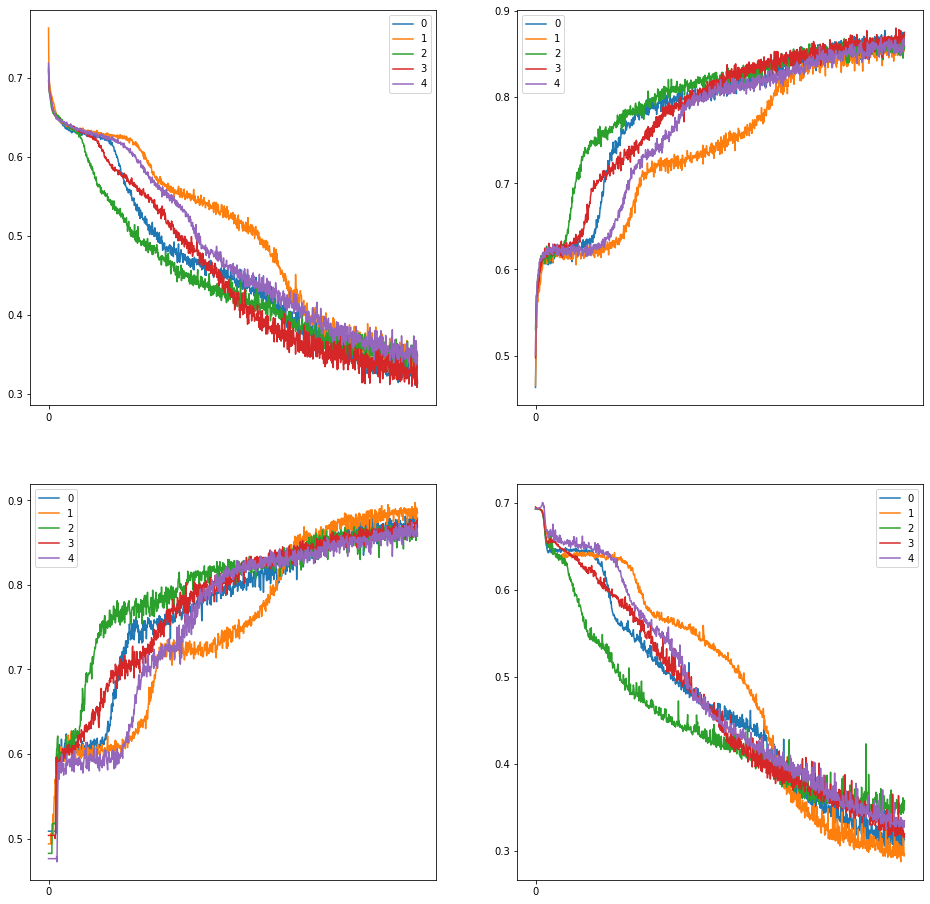

In [39]:
plot_histories(histories)

In [21]:
model_to_save = compile_model()
model_to_save.fit(X,y_binary, epochs = 400, verbose = 0, batch_size = 156, shuffle = True)
model_to_save.save('Nami-Yousef-2.h5')

In [22]:
np.savetxt('Nami-Yousef-2.txt',scalers)

# Test if evlauate works correctly

0.86375
80/80 [==============================] - 0s 2ms/step - loss: 0.3417 - accuracy: 0.8637 - binary_accuracy: 0.8637 - binary_crossentropy: 0.3417 - categorical_accuracy: 0.8637
[0.34169894456863403, 0.8637499809265137, 0.8637499809265137, 0.34169894456863403, 0.8637499809265137]
125/125 [==============================] - 0s 1ms/step - loss: 0.3455 - accuracy: 0.8575 - binary_accuracy: 0.8575 - binary_crossentropy: 0.3455 - categorical_accuracy: 0.8575
[0.3454750180244446, 0.8575000166893005, 0.8575000166893005, 0.3454750180244446, 0.8575000166893005]


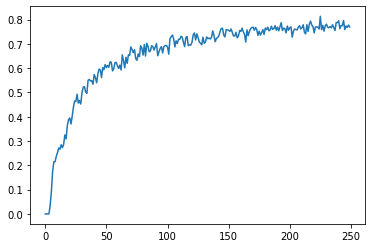

In [43]:

model = compile_model()
history = model.fit(X,y_binary,
                    #shuffle = True,
                    epochs = 250, verbose = 0, batch_size = 50, validation_split = 0.2, shuffle = True)
yhat = model.predict(data[1])
yhat = yhat[:,1]
yhat[yhat > 0.5] = 1
yhat[yhat <= 0.5] = 0

print((yhat == data[3][:,1]).sum() / yhat.shape[0])

print(model.evaluate(data[1],data[3], batch_size = 10))
print(model.evaluate(X,y_binary))
plt.plot(history.history['val_accuracy'])

# Questions that I have

- How does batch_size affect evaluation and prediction? 
- If you use 32 batchsize for fitting, then 50 or 60 for evaluation, will that affect the accuracy score that you get?
- when using validation_split, what portion of the data is being taken, and what impact does shuffle = True have on this?
- if using validation split, OR validation_data, does reulting curve give you the most accurate representation (i.e. val_accuracy) or is Kfold still more accurate?

In [33]:
# testing with validation split
model = compile_model()
start = time()
history = model.fit(X,y_binary,
                    shuffle = True, validation_split = 0.2,
                    epochs = 250, verbose = 0, batch_size = 50)
model.summary()

Model: "functional_67"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Data (InputLayer)            [(None, 6)]               0         
_________________________________________________________________
dense_165 (Dense)            (None, 16)                112       
_________________________________________________________________
batch_normalization_66 (Batc (None, 16)                64        
_________________________________________________________________
dense_166 (Dense)            (None, 8)                 136       
_________________________________________________________________
batch_normalization_67 (Batc (None, 8)                 32        
_________________________________________________________________
dense_167 (Dense)            (None, 16)                144       
_________________________________________________________________
dense_168 (Dense)            (None, 4)               

125/125 [==============================] - 0s 2ms/step - loss: 0.3505 - accuracy: 0.8605 - binary_accuracy: 0.8605 - binary_crossentropy: 0.3505 - categorical_accuracy: 0.8605


[0.35052692890167236,
 0.8604999780654907,
 0.8604999780654907,
 0.35052692890167236,
 0.8604999780654907]

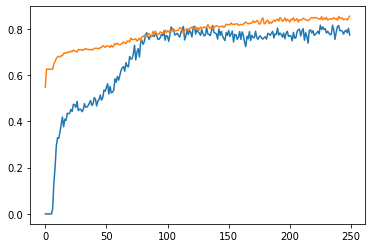

In [79]:
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'])
model.evaluate(X,y_binary)

In [12]:
instance.evaluate(epochs = 100, verbose = 0)


100/100 [==============================] - 0s 1ms/step - loss: 0.4429 - accuracy: 0.8059 - binary_accuracy: 0.8067 - binary_crossentropy: 0.4429 - categorical_accuracy: 0.8059


In [13]:
feedforward.print_params(-3)

[[0.442889928817749, 0.8059375286102295, 0.8067187666893005, 0.442889928817749, 3.5885000228881836, 482]]


In [14]:
#feedforward.plot_model()

In [15]:
#model = feedforward.get_model()
#yhat = model.predict(X_test)
#yhat = yhat[:,1]
#yhat[yhat > 0.5] = 1
#yhat[yhat <=0.5] = 0

In [16]:
#(yhat == y_test[:,1]).sum()/len(yhat)

https://dbader.org/blog/meaning-of-underscores-in-python

https://keras.io/api/layers/initializers/

https://stats.stackexchange.com/questions/330559/why-is-tanh-almost-always-better-than-sigmoid-as-an-activation-function

https://keras.io/api/losses/probabilistic_losses/#sparsecategoricalcrossentropy-class

https://ruder.io/optimizing-gradient-descent/

https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html

https://towardsai.net/p/data-science/how-when-and-why-should-you-normalize-standardize-rescale-your-data-3f083def38ff

https://github.com/keras-team/keras/pull/9965

https://medium.com/mini-distill/effect-of-batch-size-on-training-dynamics-21c14f7a716e

https://stackoverflow.com/questions/51841506/data-standardization-vs-normalization-vs-robust-scaler

https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/

https://www.kdnuggets.com/2019/12/5-techniques-prevent-overfitting-neural-networks.html


https://towardsdatascience.com/a-practical-introduction-to-early-stopping-in-machine-learning-550ac88bc8fd


https://www.quora.com/What-is-the-importance-of-the-validation-split-variable-in-Keras

https://towardsdatascience.com/applied-deep-learning-part-3-autoencoders-1c083af4d798


USE callbacks, USE leakyRELU?

https://stackoverflow.com/questions/52678215/find-input-that-maximises-output-of-a-neural-network-using-keras-and-tensorflow


https://datascience.stackexchange.com/questions/66869/setting-class-weights-for-imbalanced-dataset-how-using-earlystopping IMPORTANT


**New links**

https://keras.io/guides/functional_api/

https://keras.io/api/layers/activations/

https://www.dlology.com/blog/one-simple-trick-to-train-keras-model-faster-with-batch-normalization/
https://machinelearningmastery.com/greedy-layer-wise-pretraining-tutorial/
https://stackoverflow.com/questions/40708169/how-to-initialize-biases-in-a-keras-model
https://keras.io/api/layers/normalization_layers/batch_normalization/
https://r2rt.com/implementing-batch-normalization-in-tensorflow.html

https://stats.stackexchange.com/questions/7757/data-normalization-and-standardization-in-neural-networks

http://yann.lecun.com/exdb/publis/pdf/lecun-98b.pdf


In [93]:
# idea: run the model for different values and parameters and then use regression / calssification to find the best ones

# apparently having a small middle layer is good?

In [ ]:
# try the early stopping method that kyriacos suggested and see if it causes overfit or not


# experiment with and without validation split to see if it causes any difference!